Trabajo Practico 2

In [73]:
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors
import numpy as np
from  collections  import defaultdict
from scipy import optimize
import os
from lectura import ldata
from math import log

In [2]:
# Red de interacciones binarias(yeast_Y2H.txt)
# Red de copertenecia o complejos proteícos(yeast_AP-MS.txt)
# Red obtenida de literatura: Yeast Interactome Database(yeast_LIT.txt)

In [3]:
# El directorio que vamos a usar en cada lectura de datos de ahora en mas
directorio = os.path.dirname(os.path.realpath("yeast_AP-MS.txt"))

In [4]:
fnMS = os.path.join(directorio,'tc02Data/yeast_AP-MS.txt')
fnLIT = os.path.join(directorio,'tc02Data/yeast_LIT.txt')
fnY2H = os.path.join(directorio,'tc02Data/yeast_Y2H.txt')
fnLIT_reg = os.path.join(directorio,'tc02Data/yeast_LIT_Reguly.txt')

# Lectura de datos
datosapms=ldata(fnMS)
datoslit=ldata(fnLIT)
datosy2h=ldata(fnY2H)
datoslit_reg=ldata(fnLIT_reg)
datoslit_reg=[row[0:2] for row in datoslit_reg][1:]


In [5]:
G1 = nx.Graph()
G2 = nx.Graph()
G3 = nx.Graph()
G4 = nx.Graph()

G1.add_edges_from(datosapms)
G2.add_edges_from(datoslit)
G3.add_edges_from(datosy2h)
G4.add_edges_from(datoslit_reg)



In [6]:
# Características de las redes

# Numero total de nodos
N = [G1.number_of_nodes(),G2.number_of_nodes(),G3.number_of_nodes(),G4.number_of_nodes()]

# Numero total de enlaces
L = [G1.number_of_edges(),G2.number_of_edges(),G3.number_of_edges(),G4.number_of_edges()]

# Grado medio
kmean = [np.mean(list(dict(G1.degree).values())),np.mean(list(dict(G2.degree).values())),
         np.mean(list(dict(G3.degree).values())),
         np.mean(list(dict(G4.degree).values()))]

# Coeficiente de clustering local
clusteringlocal = [nx.average_clustering(G1),nx.average_clustering(G2),nx.average_clustering(G3),nx.average_clustering(G4)]


In [7]:
# Tabla con las caraterísticas de las redes
info= pd.DataFrame({"ID":['apms','YID_lit','y2h','lit_reg'],"nodos":N,"enlaces":L,"kmean":kmean,
                    "clusteringlocal":clusteringlocal})

In [8]:
info

,ID,clusteringlocal,enlaces,kmean,nodos
0,apms,0.554636,9070,11.183724,1622
1,YID_lit,0.292492,2925,3.808594,1536
2,y2h,0.046194,2930,2.903865,2018
3,lit_reg,0.261134,11858,7.171454,3307


In [9]:
def overlap(red1,red2):
    cant=0
    for edge in red1.edges():
        if edge in red2.edges():
            cant+=1
            
    return cant/red1.number_of_edges()

In [10]:
overlap(G1,G2)

0.14310915104740904

In [11]:
nombres=['apms','YID_lit','y2h','lit_reg']
grafos=[G1,G2,G3,G4]
columna=[0]*4
for j in np.arange(4):
    columna[j]=[0,0,0,0]
    for i in np.arange(4):
        if i==j:
            columna[j][i]=nombres[i]
        else:
            columna[j][i]=overlap(grafos[i],grafos[j])
            
tabla2=pd.DataFrame(columna)

In [12]:
tabla2

,0,1,2,3
0,apms,0.443761,0.0887372,0.212515
1,0.143109,YID_lit,0.0887372,0.241187
2,0.0286659,0.0888889,y2h,0.0403947
3,0.277839,0.977778,0.163481,lit_reg


In [13]:
fnessential = os.path.join(directorio,'tc02Data/Essential_ORFs_paperHe.txt')
essential=ldata(fnessential)
essential=[row[1] for row in essential[2:-4]]

In [14]:
def essentialhubs(grafo,essential):
    Nodos=sorted(grafo.degree, key=lambda x: x[1], reverse=True)
    CantidadHubs=np.arange(len(Nodos)+1)
    CantidadEssential=[0]
    PorcEssential=[0]
    contador=1
    for nodo in Nodos:
        if nodo[0] in essential:
            CantidadEssential.append(CantidadEssential[-1]+1)
        else:
            CantidadEssential.append(CantidadEssential[-1])
        PorcEssential.append(CantidadEssential[-1]/CantidadHubs[contador])
        #print(CantidadHubs[contador],contador)
        contador+=1
    CantidadHubs=np.array(CantidadHubs)/len(Nodos)
    return [CantidadHubs,PorcEssential]

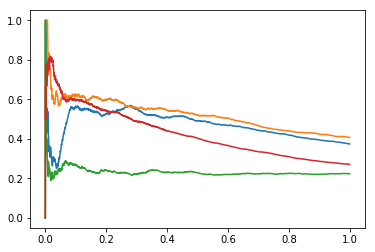

In [15]:
for i in np.arange(4):
    cantidad,esencial=essentialhubs(grafos[i],essential)
    
    plt.plot(cantidad,esencial)   
plt.show()

In [16]:
#.degree
#eigenvector_centrality(G, max_iter=100, tol=1e-06, nstart=None, weight=None)
#subgraph_centrality(G)
#betweenness_centrality(G, k=None, normalized=True, weight=None, endpoints=False, seed=None)
#current_flow_closeness_centrality(G, weight='weight', dtype=<type 'float'>, solver='lu')
#len(max(nx.connected_component_subgraphs(G1), key=len).nodes())

In [136]:
import random

In [137]:
def vulnerability(Grafo,essential):
    randomlist=[]
    fraccion=[]
    tamaño=len(list(Grafo.nodes()))
    G=Grafo.copy()
    i=0
    #El primer cuarto del grafo, sacamos de a 10 nodos por cada vez que elegimos la compontente mayor
    while len(G)>len(Grafo)*3/4:
            componente=max(nx.connected_component_subgraphs(G), key=len) #Elegimos componente
            randomlist.append(len(componente)/tamaño) # tamaño de la componente (normalizado)
            fraccion.append(i/tamaño) #Cantidad de nodos que sacamos (normalizado)
            for j in np.arange(10): #Elegimos el proximo nodo a sacar
                nodo=random.choice(list(componente.nodes())) 
                G.remove_node(nodo)
                componente.remove_node(nodo)
                i+=1
    #El segundo cuarto sacamos nodos eligiendo en cada paso la componente mayor. Paramos cuando el grafo está a la mitad de su tamaño original
    while len(G)>len(Grafo)/2:
            componente=max(nx.connected_component_subgraphs(G), key=len)
            randomlist.append(len(componente)/tamaño)
            fraccion.append(i/tamaño)
            nodo=random.choice(list(componente.nodes()))
            G.remove_node(nodo)
            i+=1

    return fraccion,randomlist

In [138]:
def vulnerabilitygrado(Grafo,essential):
    gradolist=[]
    fraccion=[]
    tamaño=len(list(Grafo.nodes()))
    G=Grafo.copy()
    i=0
#    Nodos=sorted(G.degree, key=lambda x: x[1], reverse=True)
    while len(G)>len(Grafo)*3/4:
            componente=max(nx.connected_component_subgraphs(G), key=len)
            gradolist.append(len(componente)/tamaño)
            fraccion.append(i/tamaño)
            for j in np.arange(10):
                nodo=max(componente.degree)
                G.remove_node(nodo[0])
                componente.remove_node(nodo[0])
                i+=1
    while len(G)>len(Grafo)/2:
            componente=max(nx.connected_component_subgraphs(G), key=len)
            gradolist.append(len(componente)/tamaño)
            fraccion.append(i/tamaño)
            nodo=max(componente.degree)
            G.remove_node(nodo[0])

            i+=1

    return fraccion,gradolist

In [139]:
def vulnerabilityautovec(Grafo,essential):
    autoveclist=[]
    fraccion=[]
    tamaño=len(list(Grafo.nodes()))
    G=Grafo.copy()
    i=0
    while len(G)>len(Grafo)*3/4:
            componente=max(nx.connected_component_subgraphs(G), key=len)
            autoveclist.append(len(componente)/tamaño)
            fraccion.append(i/tamaño)
            for j in np.arange(10):
                nodo=max(nx.eigenvector_centrality(componente))
                G.remove_node(nodo)
                componente.remove_node(nodo)
                i+=1    
    while len(G)>len(Grafo)/2:
        componente=max(nx.connected_component_subgraphs(G), key=len)
        autoveclist.append(len(componente)/tamaño)
        fraccion.append(i/tamaño)
        nodo=max(nx.eigenvector_centrality(componente))
        G.remove_node(nodo)
        i+=1
    return fraccion,autoveclist

In [140]:
def vulnerabilitysubgraph(Grafo,essential):
    subgraphlist=[]
    fraccion=[]
    tamaño=len(list(Grafo.nodes()))
    G=Grafo.copy()
    i=0
    while len(G)>len(Grafo)*3/4:
            componente=max(nx.connected_component_subgraphs(G), key=len)
            subgraphlist.append(len(componente)/tamaño)
            fraccion.append(i/tamaño)
            for j in np.arange(10):
                nodo=max(nx.subgraph_centrality(componente))
                G.remove_node(nodo)
                componente.remove_node(nodo)
                i+=1
    while len(G)>len(Grafo)/2:
        componente=max(nx.connected_component_subgraphs(G), key=len)
        subgraphlist.append(len(componente)/tamaño)
        fraccion.append(i/tamaño)
        nodo=max(nx.subgraph_centrality(componente))
        G.remove_node(nodo)
        i+=1
    return fraccion,subgraphlist

In [141]:
def vulnerabilitybetweeness(Grafo,essential):
    betweenesslist=[]
    fraccion=[]
    tamaño=len(list(Grafo.nodes()))
    G=Grafo.copy()
    i=0
    while len(G)>len(Grafo)*3/4:
            componente=max(nx.connected_component_subgraphs(G), key=len)
            betweenesslist.append(len(componente)/tamaño)
            fraccion.append(i/tamaño)
            for j in np.arange(10):
                nodo=max(nx.betweenness_centrality(componente, k=None, normalized=True, weight=None, endpoints=False, seed=None))
                componente.remove_node(nodo)
                G.remove_node(nodo)
                i+=1    
    while len(G)>len(Grafo)/2:
        componente=max(nx.connected_component_subgraphs(G), key=len)
        betweenesslist.append(len(componente)/tamaño)
        fraccion.append(i/tamaño)
        nodo=max(nx.betweenness_centrality(componente, k=None, normalized=True, weight=None, endpoints=False, seed=None))
        G.remove_node(nodo)
        i+=1
    return fraccion,betweenesslist

In [142]:
def vulnerabilityflow(Grafo,essential):
    flowlist=[]
    fraccion=[]
    tamaño=len(list(Grafo.nodes()))
    G=Grafo.copy()
    i=0
    Nodos=sorted(nx.current_flow_closeness_centrality(max(nx.connected_component_subgraphs(G), key=len), weight=None, solver='lu'), key=lambda x: x[1], reverse=True)
  
    while len(G)>len(Grafo)/2:
        componente=max(nx.connected_component_subgraphs(G), key=len)
        flowlist.append(len(componente)/tamaño)
        fraccion.append(i/tamaño)
        nodo=max(nx.current_flow_closeness_centrality(componente))
        G.remove_node(nodo)
        i+=1
    return fraccion,flowlist

In [143]:
def vulnerabilityessential(Grafo,essential):
    G=Grafo.copy()
    tamaño=len(list(Grafo.nodes()))
    for nodo in Grafo.nodes():
        if nodo in essential:
            G.remove_node(nodo)
            
    essential=len(max(nx.connected_component_subgraphs(G), key=len).nodes())/tamaño
    fraccion3=(len(Grafo)-len(G))/tamaño

    return fraccion3,essential,len(Grafo)-len(G)

In [ ]:
#No correr estos, salvo que queramos probar uno por uno

In [26]:
f1,lc=vulnerability(G1,essential)

In [27]:
f2,vgrado=vulnerabilitygrado(G1,essential)

In [32]:
f3,lcautovec=vulnerabilityautovec(G1,essential)

In [33]:
f4,lcsubgraph=vulnerabilitysubgraph(G1,essential)

In [34]:
f5,lcbetweeness=vulnerabilitybetweeness(G1,essential)

YPR190C
YPR189W
YPR188C
YPR187W
YPR182W
YPR178W
YPR175W
YPR174C
YPR171W
YPR169W
YPR168W
YPR149W
YPR144C
YPR140W
YPR137W
YPR112C
YPR110C
YPR108W
YPR107C
YPR103W
YPR102C
YPR101W
YPR093C
YPR088C
YPR082C
YPR080W
YPR070W
YPR067W
YPR057W
YPR052C
YPR041W
YPR036W
YPR035W
YPR034W
YPR023C
YPR016C
YPR010C
YPL266W
YPL254W
YPL249CA
YPL249C
YPL243W
YPL240C
YPL237W
YPL235W
YPL231W
YPL220W
YPL219W
YPL217C
YPL213W
YPL211W
YPL210C
YPL208W
YPL204W
YPL198W
YPL190C
YPL181W
YPL178W
YPL153C
YPL151C
YPL146C
YPL143W
YPL139C
YPL138C
YPL137C
YPL131W
YPL129W
YPL126W
YPL118W
YPL093W
YPL090C
YPL082C
YPL081W
YPL050C
YPL048W
YPL047W
YPL043W
YPL042C
YPL037C
YPL031C
YPL020C
YPL016W
YPL013C
YPL012W
YPL011C
YPL010W
YPL004C
YPL001W
YOR370C
YOR362C
YOR361C
YOR341W
YOR340C
YOR332W
YOR326W
YOR319W
YOR312C
YOR310C
YOR308C
YOR304W
YOR303W
YOR294W
YOR290C
YOR281C
YOR276W
YOR272W
YOR270C
YOR261C
YOR260W
YOR259C
YOR250C
YOR244W
YOR234C
YOR224C
YOR210W
YOR207C
YOR206W
YOR204W
YOR198C
YOR179C
YOR174W
YOR160W
YOR159C
YOR157C
YOR151C

In [98]:
f6,lcflow=vulnerabilityflow(G1,essential)

KeyboardInterrupt: 

In [36]:
f7,lcessential,cant=vulnerabilityessential(G1,essential)

In [145]:
#Todo Junto
G=G3 #Hay que cambiar para hacer el de otros graficos
#Para el metodo random realizamos 10 iteraciones y elegimos el promedio de todas
lcs=[]
for i in np.arange(3):
    f1,lista=vulnerability(G1,essential)
    lcs.append(lista)
lc=[np.mean(a) for a in list((zip(lcs[0],lcs[1],lcs[2])))]
#El resto de los metodos
f2,vgrado=vulnerabilitygrado(G,essential)
#f3,lcautovec=vulnerabilityautovec(G,essential)
f4,lcsubgraph=vulnerabilitysubgraph(G,essential)
f5,lcbetweeness=vulnerabilitybetweeness(G,essential)
f6,lcflow=vulnerabilityflow(G,essential)
f7,lcessential,cant=vulnerabilityessential(G,essential)


KeyboardInterrupt: 

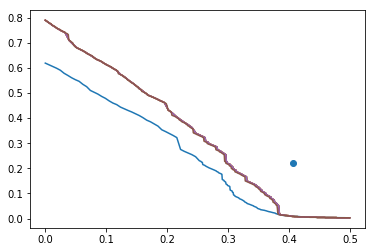

In [132]:

plt.plot(f1,lc)
plt.plot(f2,vgrado)
plt.plot(f3,lcautovec)
plt.plot(f4,lcsubgraph)
plt.plot(f5,lcbetweeness)
plt.plot(f6,lcflow)
plt.scatter(f7,lcessential)
plt.show()

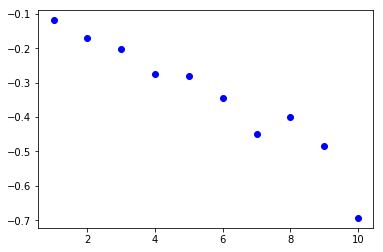

In [188]:
#Tabla de HE
Grafo=G4.copy()
HEnorm={}
HEessencial={}
for nodo in Grafo.nodes():
    grado=Grafo.degree(nodo)
    if grado<11:
        try:
            HEnorm[grado]+=1
        except:
            HEnorm[grado]=1

        if nodo in essential:
            try:
                HEessencial[grado]+=1
            except:
                HEessencial[grado]=1

Porc={}
for i in sorted(HEnorm.keys()):
    try:
        Porc[i]=log(1-(HEessencial[i]/HEnorm[i]))
    except:
        Porc[i]=log(1)
plt.plot(Porc.keys(),Porc.values(),'bo')
plt.show()

-0.043769407910835056 -0.05420421216918925


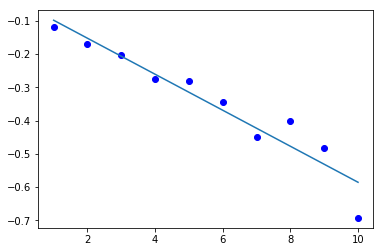

In [189]:

# Ajuste de la recta

datox=np.array(list(Porc.keys()))
datoy=np.array(list(Porc.values()))

fitfunc = lambda p, x: p[0] + x* p[1] 
errfunc = lambda p, x, y: (y - fitfunc(p, x)) 

pinit = [1, 1]
out = optimize.leastsq(errfunc, pinit,  args=(datox,datoy), full_output=1)
pfinal = out[0]


print(pfinal[0],pfinal[1])

recta=[fitfunc(pfinal,x) for x in datox ]

plt.clf()
plt.plot(datox,datoy,'bo')
plt.plot(datox, recta)     # Fit
plt.show()

In [180]:
def gradoesencial(Grafo,essential):
        G=Grafo.copy()
        tamaño=np.max(list(dict(G.degree()).values()))
        gradosdeesencial={}
        for i in range(tamaño+1):
                gradosdeesencial[i]=0

        for nodo in G.nodes():
            if nodo in essential:
                gradosdeesencial[G.degree[nodo]]+=1
    
        return gradosdeesencial



def seleccionar(Grafo,essential,gradosdeesencial):
        G=Grafo.copy()
        listadeseleccion=[]

        diccionariodegrados=dict(G.degree())

        for gradoorden in gradosdeesencial.keys():
                listaseleccionadaporgrados=[]
                listaparaagregar=[]
                for nodos,grados in diccionariodegrados.items():
                        if grados==gradoorden:
                                listaseleccionadaporgrados.append(nodos)
                listaparaagregar=random.sample(listaseleccionadaporgrados,gradosdeesencial[gradoorden])
                listadeseleccion.extend(listaparaagregar)
        return listadeseleccion

In [182]:
def randomcongrado(grafo,essential):
    randomlist=[]
    for i in np.arange(100):
        gradoesencial1=gradoesencial(grafo,essential)
        lista=seleccionar(grafo,essential,gradoesencial1)
        f,reslista,cant= vulnerabilityessential(grafo,lista)
        randomlist.append(reslista)
    M=np.mean(reslista)
    S=np.std(reslista)
    return M,S

In [193]:
i=0
ESSENTIAL=[0]*4
MEAN=[0]*4
STD=[0]*4
for grafo in grafos:
    f,ESSENTIAL[i],cant= vulnerabilityessential(grafo,essential)
    MEAN[i],STD[i]=randomcongrado(grafo,essential)
    i+=1

In [203]:
STD

[0.0, 0.0, 0.0, 0.0]

In [201]:
Tabla3= pd.DataFrame({"ID":['apms','YID_lit','y2h','lit_reg'],"essential":ESSENTIAL,"random":MEAN,"error":STD})

In [204]:
print(Tabla3)

        ID  error  essential    random
0     apms    0.0   0.200370  0.161529
1  YID_lit    0.0   0.222005  0.087240
2      y2h    0.0   0.509415  0.475223
3  lit_reg    0.0   0.560629  0.504687
